# 🧱 DCGAN - 블록 데이터

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py와 vae_utils.py, download_kaggle_data.sh를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2023-05-24 01:38:39--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2023-05-24 01:38:39 (36.9 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 레고 블록 데이터셋에서 DCGAN을 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. 데이터 준비 <a name="prepare"></a>

In [5]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # 캐글-->Setttings-->API-->Create New Token에서 
    # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    !kaggle datasets download -d joosthazelzet/lego-brick-images
    !unzip -q lego-brick-images.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

Saving kaggle.json to kaggle.json
 99% 0.99G/1.00G [00:33<00:00, 48.7MB/s]
100% 1.00G/1.00G [00:34<00:00, 31.4MB/s]


In [6]:
train_data = utils.image_dataset_from_directory(
    "./dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [7]:
def preprocess(img):
    """
    이미지 정규화 및 크기 변경
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

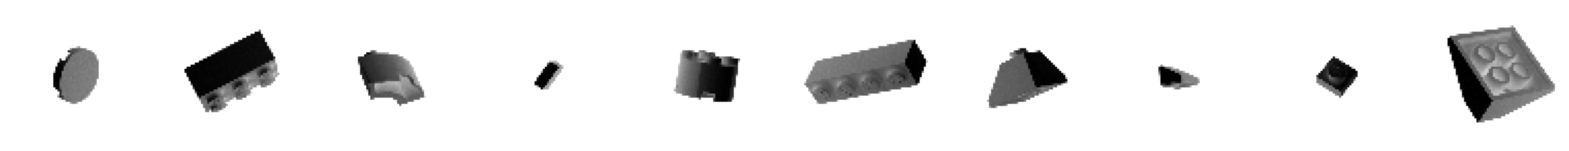

In [9]:
display(train_sample)

## 2. GAN 구축 <a name="build"></a>

In [10]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [12]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# DCGAN 생성
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [14]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. GAN 훈련 <a name="train"></a>

In [15]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [16]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해 
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )

Epoch 1/300
  6/313 [..............................] - ETA: 51s - d_loss: 0.1248 - d_real_acc: 0.9232 - d_fake_acc: 0.8398 - d_acc: 0.8815 - g_loss: 2.2698 - g_acc: 0.1602

313/313 [==============================] - ETA: 0s - d_loss: 0.1948 - d_real_acc: 0.8546 - d_fake_acc: 0.8656 - d_acc: 0.8601 - g_loss: 4.9992 - g_acc: 0.1344
Saved to ./output/generated_img_000.png


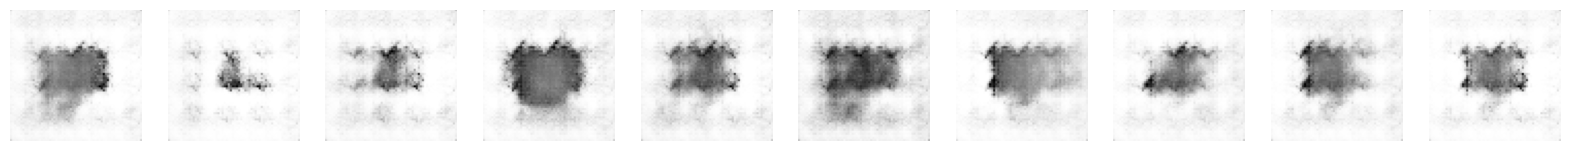

313/313 [==============================] - 93s 241ms/step - d_loss: 0.1948 - d_real_acc: 0.8546 - d_fake_acc: 0.8656 - d_acc: 0.8601 - g_loss: 4.9992 - g_acc: 0.1344
Epoch 2/300
313/313 [==============================] - 77s 241ms/step - d_loss: 0.0415 - d_real_acc: 0.9052 - d_fake_acc: 0.9177 - d_acc: 0.9115 - g_loss: 5.1725 - g_acc: 0.0823
Epoch 3/300
313/313 [==============================] - 78s 245ms/step - d_loss: 0.0435 - d_real_acc: 0.9037 - d_fake_acc: 0.9099 - d_acc: 0.9068 - g_loss: 5.9863 - g_acc: 0.0901
Epoch 4/300
313/313 [==============================] - 79s 247ms/step - d_loss: 0.0332 - d_real_acc: 0.9022 - d_fake_acc: 0.9047 - d_acc: 0.9035 - g_loss: 5.0797 - g_acc: 0.0953
Epoch 5/300
313/313 [==============================] - 77s 241ms/step - d_loss: 0.0860 - d_real_acc: 0.8871 - d_fake_acc: 0.8882 - d_acc: 0.8877 - g_loss: 4.8733 - g_acc: 0.1117
Epoch 6/300
313/313 [==============================] - 77s 242ms/step - d_loss: 0.0711 - d_real_acc: 0.8932 - d_fake_acc: 

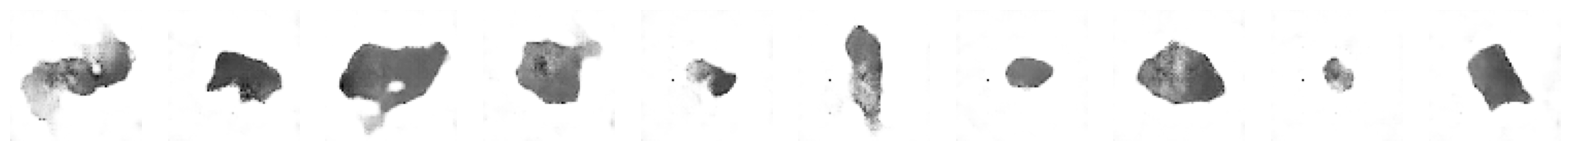

313/313 [==============================] - 78s 244ms/step - d_loss: 0.0381 - d_real_acc: 0.9088 - d_fake_acc: 0.9075 - d_acc: 0.9081 - g_loss: 4.7916 - g_acc: 0.0926
Epoch 12/300
313/313 [==============================] - 79s 247ms/step - d_loss: 0.0374 - d_real_acc: 0.9105 - d_fake_acc: 0.9092 - d_acc: 0.9099 - g_loss: 5.1236 - g_acc: 0.0908
Epoch 13/300
313/313 [==============================] - 77s 243ms/step - d_loss: 0.0466 - d_real_acc: 0.9103 - d_fake_acc: 0.9102 - d_acc: 0.9102 - g_loss: 5.3146 - g_acc: 0.0898
Epoch 14/300
313/313 [==============================] - 79s 247ms/step - d_loss: 0.0084 - d_real_acc: 0.9190 - d_fake_acc: 0.9194 - d_acc: 0.9192 - g_loss: 5.3142 - g_acc: 0.0806
Epoch 15/300
313/313 [==============================] - 77s 240ms/step - d_loss: -0.0378 - d_real_acc: 0.9237 - d_fake_acc: 0.9252 - d_acc: 0.9244 - g_loss: 5.5361 - g_acc: 0.0748
Epoch 16/300
313/313 [==============================] - 77s 242ms/step - d_loss: 0.0093 - d_real_acc: 0.9159 - d_fake

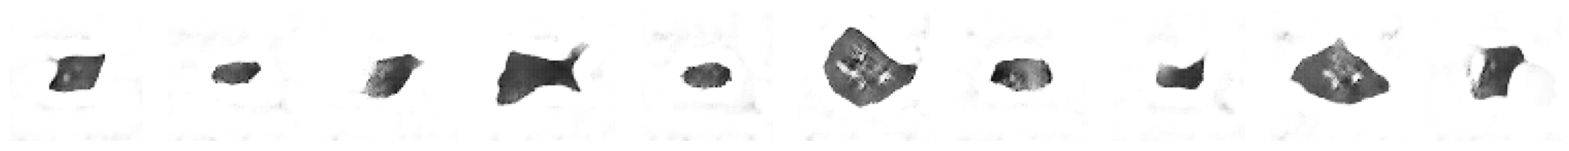

313/313 [==============================] - 77s 240ms/step - d_loss: -0.0852 - d_real_acc: 0.9344 - d_fake_acc: 0.9380 - d_acc: 0.9362 - g_loss: 6.5364 - g_acc: 0.0620
Epoch 22/300
313/313 [==============================] - 78s 246ms/step - d_loss: -0.0181 - d_real_acc: 0.9228 - d_fake_acc: 0.9237 - d_acc: 0.9233 - g_loss: 6.3672 - g_acc: 0.0763
Epoch 23/300
313/313 [==============================] - 76s 236ms/step - d_loss: -0.1253 - d_real_acc: 0.9391 - d_fake_acc: 0.9414 - d_acc: 0.9403 - g_loss: 6.9389 - g_acc: 0.0586
Epoch 24/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.0983 - d_real_acc: 0.9342 - d_fake_acc: 0.9338 - d_acc: 0.9340 - g_loss: 6.9847 - g_acc: 0.0662
Epoch 25/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.0088 - d_real_acc: 0.9214 - d_fake_acc: 0.9273 - d_acc: 0.9244 - g_loss: 6.6058 - g_acc: 0.0727
Epoch 26/300
313/313 [==============================] - 74s 232ms/step - d_loss: -0.1954 - d_real_acc: 0.9348 - d

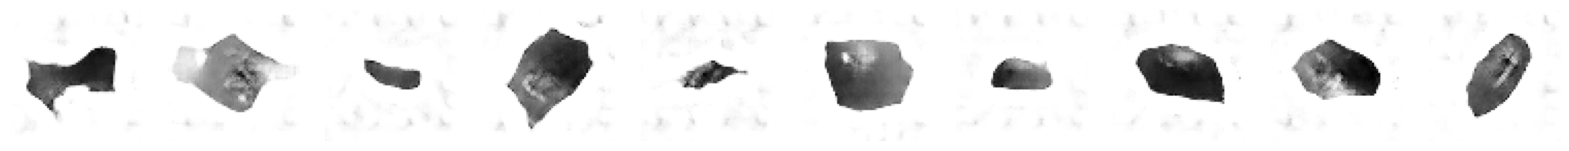

313/313 [==============================] - 75s 235ms/step - d_loss: -0.1729 - d_real_acc: 0.9400 - d_fake_acc: 0.9414 - d_acc: 0.9407 - g_loss: 8.0074 - g_acc: 0.0586
Epoch 32/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.0344 - d_real_acc: 0.9265 - d_fake_acc: 0.9377 - d_acc: 0.9321 - g_loss: 7.7763 - g_acc: 0.0623
Epoch 33/300
313/313 [==============================] - 76s 238ms/step - d_loss: 0.0236 - d_real_acc: 0.9174 - d_fake_acc: 0.9500 - d_acc: 0.9337 - g_loss: 8.6752 - g_acc: 0.0499
Epoch 34/300
313/313 [==============================] - 76s 237ms/step - d_loss: -0.1182 - d_real_acc: 0.9402 - d_fake_acc: 0.9430 - d_acc: 0.9416 - g_loss: 8.1344 - g_acc: 0.0570
Epoch 35/300
313/313 [==============================] - 76s 239ms/step - d_loss: -0.3114 - d_real_acc: 0.9595 - d_fake_acc: 0.9622 - d_acc: 0.9609 - g_loss: 9.1923 - g_acc: 0.0378
Epoch 36/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.1165 - d_real_acc: 0.9344 - d_

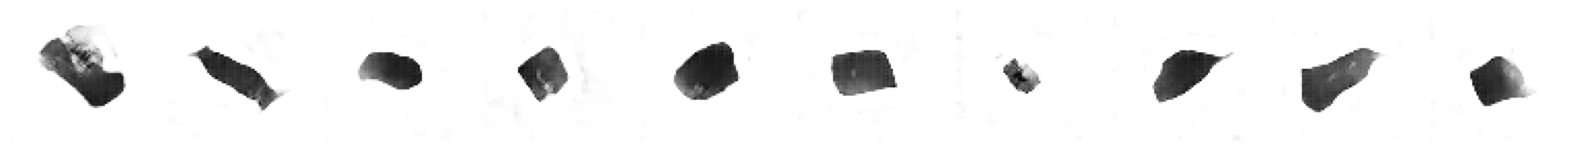

313/313 [==============================] - 76s 237ms/step - d_loss: -0.3359 - d_real_acc: 0.9642 - d_fake_acc: 0.9660 - d_acc: 0.9651 - g_loss: 9.7677 - g_acc: 0.0340
Epoch 42/300
313/313 [==============================] - 74s 232ms/step - d_loss: -0.2168 - d_real_acc: 0.9388 - d_fake_acc: 0.9388 - d_acc: 0.9388 - g_loss: 9.6514 - g_acc: 0.0611
Epoch 43/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.1635 - d_real_acc: 0.9437 - d_fake_acc: 0.9622 - d_acc: 0.9530 - g_loss: 9.7216 - g_acc: 0.0378
Epoch 44/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.1009 - d_real_acc: 0.9329 - d_fake_acc: 0.9602 - d_acc: 0.9466 - g_loss: 9.8650 - g_acc: 0.0398
Epoch 45/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.0499 - d_real_acc: 0.9230 - d_fake_acc: 0.9313 - d_acc: 0.9271 - g_loss: 8.6233 - g_acc: 0.0687
Epoch 46/300
313/313 [==============================] - 76s 239ms/step - d_loss: -0.5517 - d_real_acc: 0.9820 - d

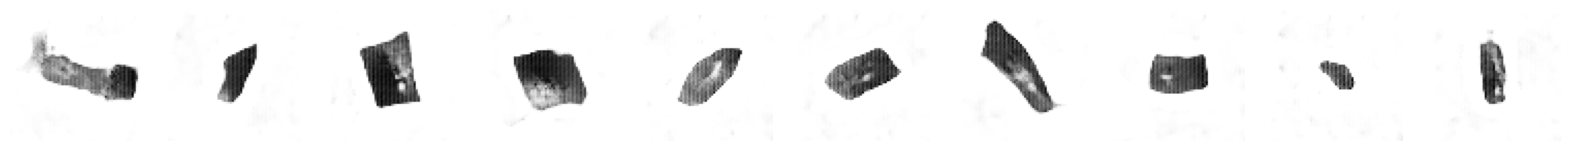

313/313 [==============================] - 74s 232ms/step - d_loss: -0.7667 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4230 - g_acc: 0.0000e+00
Epoch 52/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.7667 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4232 - g_acc: 0.0000e+00
Epoch 53/300
313/313 [==============================] - 75s 233ms/step - d_loss: 0.2110 - d_real_acc: 0.8844 - d_fake_acc: 0.9357 - d_acc: 0.9100 - g_loss: 11.4583 - g_acc: 0.0643
Epoch 54/300
313/313 [==============================] - 75s 233ms/step - d_loss: -0.3535 - d_real_acc: 0.9562 - d_fake_acc: 0.9554 - d_acc: 0.9558 - g_loss: 11.2327 - g_acc: 0.0446
Epoch 55/300
313/313 [==============================] - 76s 236ms/step - d_loss: -0.7591 - d_real_acc: 0.9994 - d_fake_acc: 0.9990 - d_acc: 0.9992 - g_loss: 15.2840 - g_acc: 0.0010
Epoch 56/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.7639 - d_real_acc

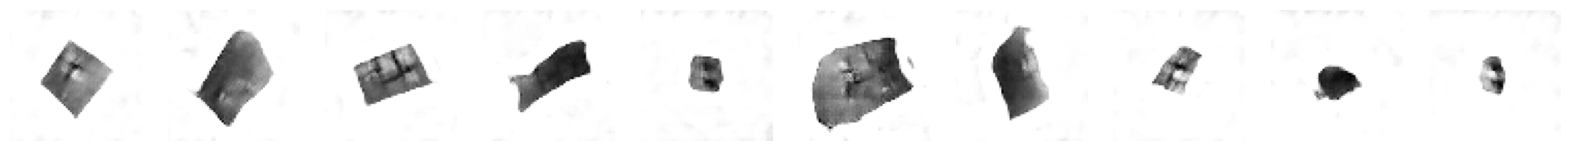

313/313 [==============================] - 76s 238ms/step - d_loss: -0.1703 - d_real_acc: 0.9432 - d_fake_acc: 0.9461 - d_acc: 0.9447 - g_loss: 8.6607 - g_acc: 0.0539
Epoch 62/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.3435 - d_real_acc: 0.9557 - d_fake_acc: 0.9610 - d_acc: 0.9583 - g_loss: 11.1593 - g_acc: 0.0390
Epoch 63/300
313/313 [==============================] - 74s 232ms/step - d_loss: -0.7642 - d_real_acc: 0.9999 - d_fake_acc: 0.9999 - d_acc: 0.9999 - g_loss: 15.2999 - g_acc: 1.2500e-04
Epoch 64/300
313/313 [==============================] - 73s 228ms/step - d_loss: -0.7643 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4244 - g_acc: 0.0000e+00
Epoch 65/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.0075 - d_real_acc: 0.9154 - d_fake_acc: 0.9406 - d_acc: 0.9280 - g_loss: 10.0537 - g_acc: 0.0594
Epoch 66/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.6061 - d_real_acc

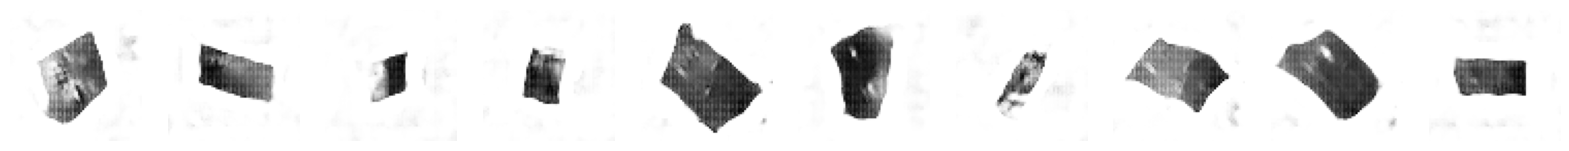

313/313 [==============================] - 74s 232ms/step - d_loss: -0.5451 - d_real_acc: 0.9809 - d_fake_acc: 0.9814 - d_acc: 0.9811 - g_loss: 12.2616 - g_acc: 0.0187
Epoch 72/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.5428 - d_real_acc: 0.9777 - d_fake_acc: 0.9808 - d_acc: 0.9793 - g_loss: 13.3611 - g_acc: 0.0192
Epoch 73/300
313/313 [==============================] - 74s 231ms/step - d_loss: -0.4625 - d_real_acc: 0.9667 - d_fake_acc: 0.9769 - d_acc: 0.9718 - g_loss: 12.9874 - g_acc: 0.0231
Epoch 74/300
313/313 [==============================] - 74s 231ms/step - d_loss: -0.3938 - d_real_acc: 0.9579 - d_fake_acc: 0.9735 - d_acc: 0.9657 - g_loss: 13.1871 - g_acc: 0.0266
Epoch 75/300
313/313 [==============================] - 74s 232ms/step - d_loss: -0.5639 - d_real_acc: 0.9772 - d_fake_acc: 0.9789 - d_acc: 0.9780 - g_loss: 13.7543 - g_acc: 0.0211
Epoch 76/300
313/313 [==============================] - 74s 231ms/step - d_loss: -0.0273 - d_real_acc: 0.916

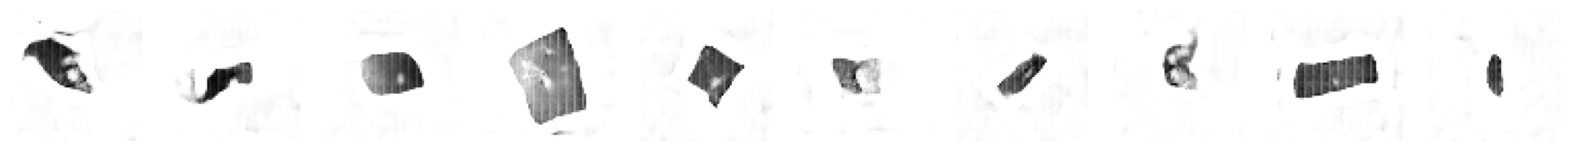

313/313 [==============================] - 74s 231ms/step - d_loss: -0.7683 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4244 - g_acc: 0.0000e+00
Epoch 82/300
313/313 [==============================] - 73s 229ms/step - d_loss: -0.7640 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.3829 - g_acc: 0.0000e+00
Epoch 83/300
313/313 [==============================] - 74s 230ms/step - d_loss: -0.7652 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 84/300
313/313 [==============================] - 73s 228ms/step - d_loss: -0.7677 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 85/300
313/313 [==============================] - 73s 228ms/step - d_loss: -0.7716 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 86/300
313/313 [==============================] - 74s 231ms/step - d_loss: -0.7668

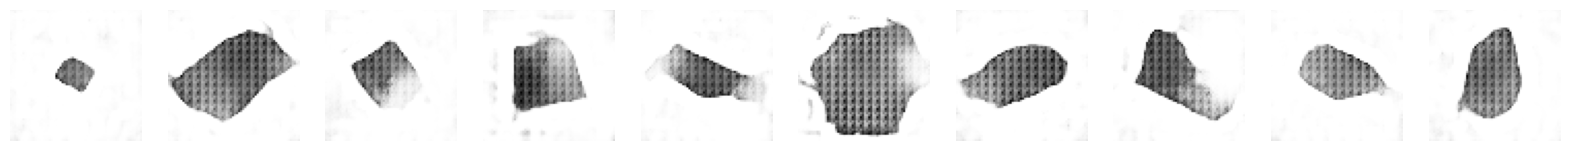

313/313 [==============================] - 73s 229ms/step - d_loss: -0.7692 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 92/300
313/313 [==============================] - 74s 231ms/step - d_loss: -0.7667 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 93/300
313/313 [==============================] - 73s 228ms/step - d_loss: -0.7673 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 94/300
313/313 [==============================] - 73s 229ms/step - d_loss: -0.7674 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 95/300
313/313 [==============================] - 74s 232ms/step - d_loss: -0.7661 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 96/300
313/313 [==============================] - 73s 229ms/step - d_loss: -0.7656

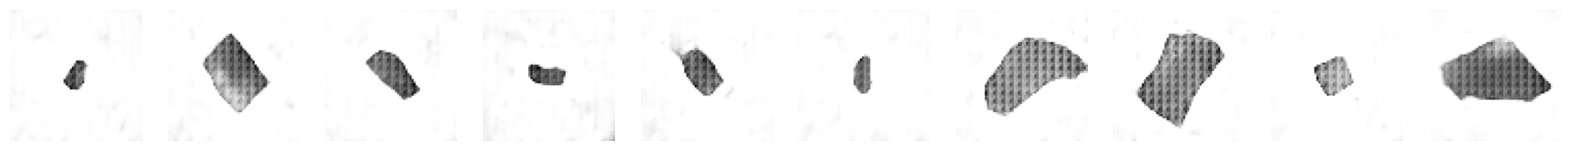

313/313 [==============================] - 75s 234ms/step - d_loss: -0.7670 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 102/300
313/313 [==============================] - 73s 230ms/step - d_loss: -0.7629 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 103/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.7658 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 104/300
313/313 [==============================] - 73s 230ms/step - d_loss: -0.5967 - d_real_acc: 0.9859 - d_fake_acc: 0.9894 - d_acc: 0.9877 - g_loss: 15.1762 - g_acc: 0.0105
Epoch 105/300
313/313 [==============================] - 74s 232ms/step - d_loss: -0.7677 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Epoch 106/300
313/313 [==============================] - 75s 235ms/step - d_loss: 4.6826

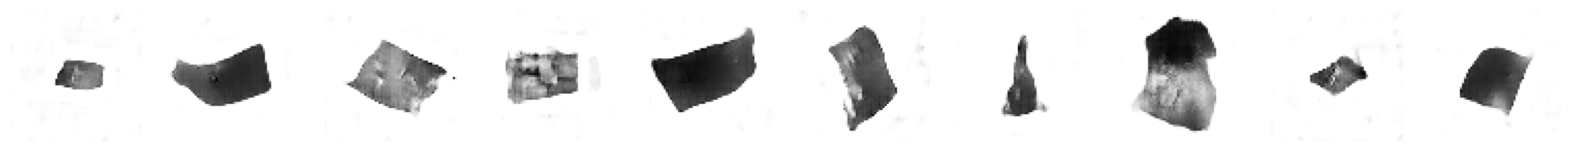

313/313 [==============================] - 75s 235ms/step - d_loss: -0.3340 - d_real_acc: 0.9634 - d_fake_acc: 0.9639 - d_acc: 0.9636 - g_loss: 9.5119 - g_acc: 0.0361
Epoch 112/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.3791 - d_real_acc: 0.9696 - d_fake_acc: 0.9722 - d_acc: 0.9709 - g_loss: 10.3069 - g_acc: 0.0278
Epoch 113/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.2138 - d_real_acc: 0.9449 - d_fake_acc: 0.9458 - d_acc: 0.9454 - g_loss: 8.9831 - g_acc: 0.0542
Epoch 114/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.3102 - d_real_acc: 0.9574 - d_fake_acc: 0.9585 - d_acc: 0.9580 - g_loss: 9.5307 - g_acc: 0.0415
Epoch 115/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.4065 - d_real_acc: 0.9685 - d_fake_acc: 0.9693 - d_acc: 0.9689 - g_loss: 10.4407 - g_acc: 0.0307
Epoch 116/300
313/313 [==============================] - 74s 233ms/step - d_loss: -0.3291 - d_real_acc: 0.9

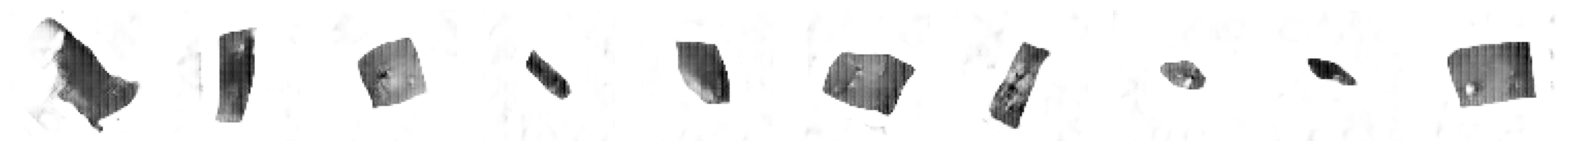

313/313 [==============================] - 76s 237ms/step - d_loss: -0.7640 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4242 - g_acc: 0.0000e+00
Epoch 122/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.7641 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4238 - g_acc: 0.0000e+00
Epoch 123/300
313/313 [==============================] - 77s 242ms/step - d_loss: -0.7614 - d_real_acc: 0.9995 - d_fake_acc: 0.9997 - d_acc: 0.9996 - g_loss: 15.2868 - g_acc: 3.0000e-04
Epoch 124/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.7657 - d_real_acc: 0.9999 - d_fake_acc: 0.9999 - d_acc: 0.9999 - g_loss: 15.4065 - g_acc: 5.0000e-05
Epoch 125/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.7661 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 126/300
313/313 [==============================] - 76s 239ms/step - d_loss: -0

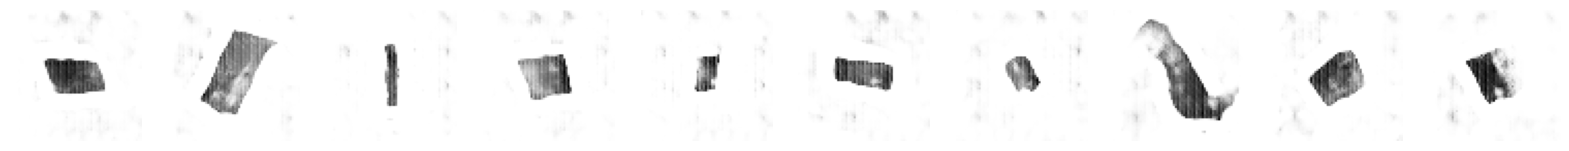

313/313 [==============================] - 76s 238ms/step - d_loss: -0.7638 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 132/300
313/313 [==============================] - 76s 237ms/step - d_loss: -0.7663 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Epoch 133/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.7662 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Epoch 134/300
313/313 [==============================] - 76s 238ms/step - d_loss: -0.7661 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 135/300
313/313 [==============================] - 76s 238ms/step - d_loss: -0.7657 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 136/300
313/313 [==============================] - 76s 237ms/step - d_loss: -0

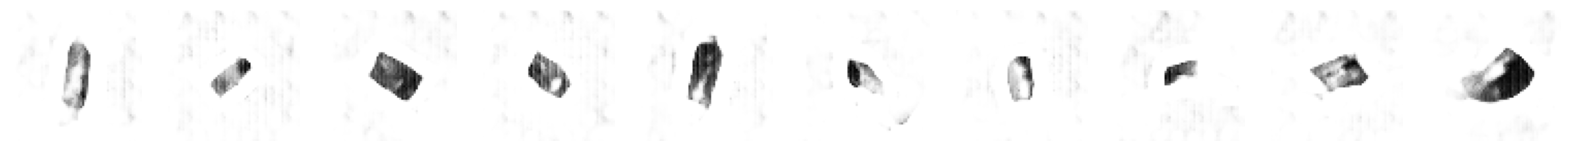

313/313 [==============================] - 76s 237ms/step - d_loss: -0.7667 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4248 - g_acc: 0.0000e+00
Epoch 142/300
313/313 [==============================] - 76s 238ms/step - d_loss: 0.8326 - d_real_acc: 0.7398 - d_fake_acc: 0.7255 - d_acc: 0.7327 - g_loss: 7.5039 - g_acc: 0.2745
Epoch 143/300
313/313 [==============================] - 78s 243ms/step - d_loss: 0.8475 - d_real_acc: 0.7386 - d_fake_acc: 0.7713 - d_acc: 0.7549 - g_loss: 6.3482 - g_acc: 0.2287
Epoch 144/300
313/313 [==============================] - 77s 241ms/step - d_loss: -0.6803 - d_real_acc: 0.9900 - d_fake_acc: 0.9913 - d_acc: 0.9906 - g_loss: 14.5712 - g_acc: 0.0087
Epoch 145/300
313/313 [==============================] - 76s 238ms/step - d_loss: -0.7579 - d_real_acc: 0.9999 - d_fake_acc: 0.9999 - d_acc: 0.9999 - g_loss: 15.3217 - g_acc: 7.5000e-05
Epoch 146/300
313/313 [==============================] - 78s 243ms/step - d_loss: -0.7676 - d_real_a

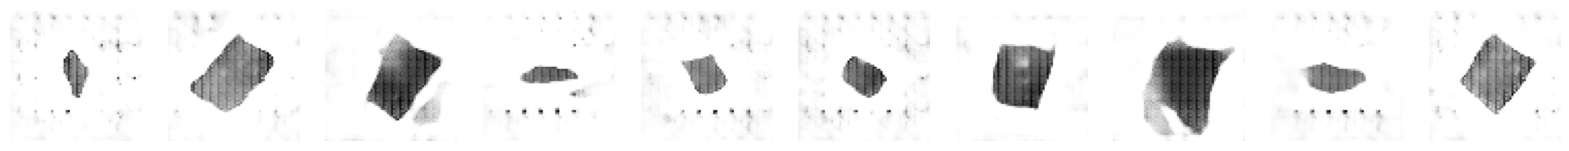

313/313 [==============================] - 76s 238ms/step - d_loss: 0.7273 - d_real_acc: 0.7800 - d_fake_acc: 0.8680 - d_acc: 0.8240 - g_loss: 10.0108 - g_acc: 0.1320
Epoch 152/300
313/313 [==============================] - 77s 239ms/step - d_loss: -0.5060 - d_real_acc: 0.9695 - d_fake_acc: 0.9746 - d_acc: 0.9720 - g_loss: 13.2538 - g_acc: 0.0255
Epoch 153/300
313/313 [==============================] - 77s 241ms/step - d_loss: -0.1926 - d_real_acc: 0.9436 - d_fake_acc: 0.9456 - d_acc: 0.9446 - g_loss: 8.5850 - g_acc: 0.0543
Epoch 154/300
313/313 [==============================] - 76s 239ms/step - d_loss: -0.5072 - d_real_acc: 0.9837 - d_fake_acc: 0.9828 - d_acc: 0.9833 - g_loss: 11.6913 - g_acc: 0.0172
Epoch 155/300
313/313 [==============================] - 77s 240ms/step - d_loss: -0.2514 - d_real_acc: 0.9457 - d_fake_acc: 0.9488 - d_acc: 0.9472 - g_loss: 9.3192 - g_acc: 0.0512
Epoch 156/300
313/313 [==============================] - 76s 238ms/step - d_loss: -0.5006 - d_real_acc: 0.9

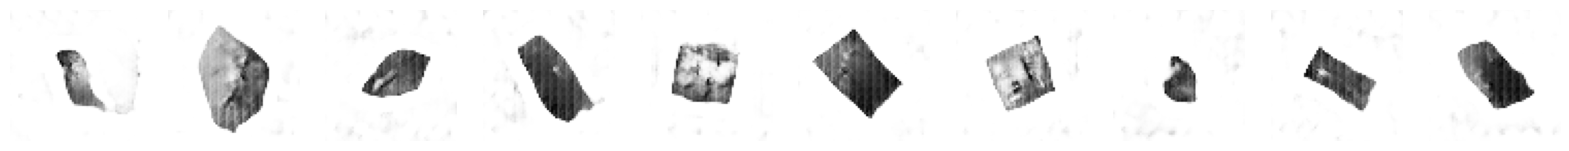

313/313 [==============================] - 76s 238ms/step - d_loss: -0.7648 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4243 - g_acc: 0.0000e+00
Epoch 162/300
313/313 [==============================] - 75s 236ms/step - d_loss: -0.7681 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4236 - g_acc: 0.0000e+00
Epoch 163/300
313/313 [==============================] - 76s 235ms/step - d_loss: -0.7620 - d_real_acc: 0.9999 - d_fake_acc: 0.9998 - d_acc: 0.9999 - g_loss: 15.3503 - g_acc: 1.5000e-04
Epoch 164/300
313/313 [==============================] - 77s 238ms/step - d_loss: -0.7668 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4045 - g_acc: 2.5000e-05
Epoch 165/300
313/313 [==============================] - 75s 235ms/step - d_loss: -0.7673 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 166/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0

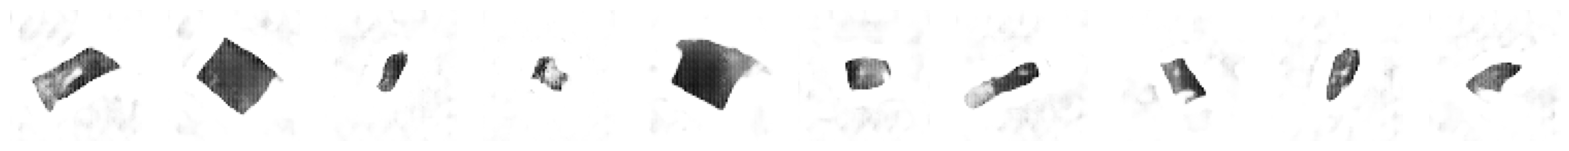

313/313 [==============================] - 76s 238ms/step - d_loss: -0.7672 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 172/300
313/313 [==============================] - 76s 238ms/step - d_loss: -0.7636 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 173/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.7686 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Epoch 174/300
313/313 [==============================] - 75s 234ms/step - d_loss: -0.7683 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Epoch 175/300
 56/313 [====>.........................] - ETA: 1:00 - d_loss: -0.7687 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00

In [ ]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# 최종 모델 저장
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. 새로운 이미지 생성 <a name="decode"></a>

In [ ]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# 샘플링된 포인트 디코딩
reconstructions = generator.predict(z_sample)

In [ ]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()